In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0010.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.23475175, 42.48479424)>


In [3]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2V Reduced')
file = 'reduceducdM_0010.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -10<(k-xref)<10 and -10<(l-yref)<10:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[454.59259704 628.36375434 424.0059529  254.90843145 323.33609575
 277.66455101 613.67733958 651.50472702 689.8070213  559.36859425]
[304.75144553 290.00495178 135.49302604 457.8531252  126.13606806
 371.80204015 137.17393335 356.15136798 472.64831724 544.99859838]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag   
--- --------- --------- ---------- ... --- --------- --------- ---------
215 452.40175  301.6133 0.50007583 ...   0 183.00465 11.371611 -2.639555
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
206 627.45748   287.065 0.4332741 ...   0 100.89818 6.7512152 -2.0734549
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
 83 423.24391 135.04901 0.44971362 ...   0 1928.7147 124.66125 -5.2393287
 id xcentroid ycentroid sharpness  ... sky   peak      flux      mag    
-

In [4]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=5) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.73573127 -21.7837264 ]
[[ 0.00246794 -0.02848349]
 [-0.02848349  0.33647895]]
Beta: [  0.64013313 -20.55728685]
Beta Std Error: [0.06060275 0.84774991]
Beta Covariance: [[ 2.59217291e-05 -3.59207940e-04]
 [-3.59207940e-04  5.07241541e-03]]
Residual Variance: 141.6839613511291
Inverse Condition #: 0.054408752780868874
Reason(s) for Halting:
  Sum of squares convergence


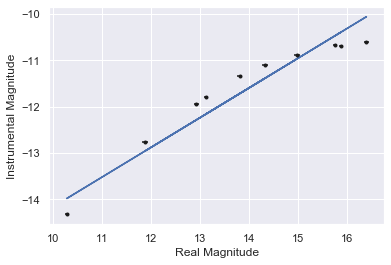

In [5]:
mags = np.array(mags)
realmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.323,11.868,14.98]
realmag = np.array(realmag)
realmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [6]:
xref = 401
yref = 372

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
384 557.79169 544.21799 0.50241589 ...   0 435.94066   27.8793  -3.6132047
263 399.81767 371.08294 0.46520914 ...   0 57692.512 3819.1481  -8.9549163
275 392.43092 378.41973 0.75173939 ...   0 121.56481 2.1769739 -0.84463306


In [7]:
sourcemag = []
sourcemagerror = []
position = [(399.81767,371.08294)]
aperture = CircularAperture(position[0], r=5) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-15.004581963735946]


In [8]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

8.674296975310302 +/- 1.5582859393609216
